In [12]:
import os
import pandas as pd
import numpy as np
from numpy import linalg as LA
import nltk
import ssl
from alive_progress import alive_bar
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
nltk.download('punkt')
ROOT_DIR = os.path.dirname(os.path.abspath("__file__"))
PARENT_DIR = os.path.dirname(ROOT_DIR)
GUARDIAN_DIR = os.path.join(ROOT_DIR, "data", "Guardian.csv")
REUTERS_DIR = os.path.join(ROOT_DIR, "data", "Reuters.csv")

[nltk_data] Downloading package punkt to /Users/r2/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [13]:
def index(article_text):

    # dictionaries
    economic_terms = ["economy", "economic"]
    uncertainty_terms = []
    with open(os.path.join(ROOT_DIR,"data","LoughranMcDonald_Uncertainty.txt"),'r') as f:
        for line in f:
            uncertainty_terms.append(line.lower().replace('\n',""))
    article_vocab = [word.lower() for word in nltk.word_tokenize(article_text) if word.isalpha()]

    common_uncertainty_terms = list(set(article_vocab).intersection(uncertainty_terms))
    common_economic_terms = list(set(article_vocab).intersection(economic_terms))

    if len(common_economic_terms) == 0 or len(common_uncertainty_terms) == 0:
        return None

    # trained vectors
    def load_glove_model(terms):
        common_vectors = []
        with open(os.path.join(ROOT_DIR,"glove_data","results","vectors.txt"),'r') as f:
            for line in f:
                if line.split(None,1)[0] in terms:
                    common_vectors.append(line.replace('\n',""))
        
        glove_model = {}
        for line in common_vectors:
            split_line = line.split()
            word = split_line[0]
            embedding = np.array(split_line[1:], dtype=np.float64)
            glove_model[word] = embedding
        return glove_model

    # index
    common_uncertainty_vectors = load_glove_model(common_uncertainty_terms)
    common_economic_vectors = load_glove_model(common_economic_terms)

    common_uncertainty_matrix = np.array(list(common_uncertainty_vectors.values()))
    common_economic_matrix = np.array(list(common_economic_vectors.values()))

    norm_uncertainty_matrix = LA.norm(common_uncertainty_matrix)
    norm_economic_matrix = LA.norm(common_economic_matrix)

    sum_common_uncertainty_terms = np.sum(common_uncertainty_matrix, axis=0)
    sum_common_economic_terms = np.sum(common_economic_matrix, axis=0)

    inner = (sum_common_economic_terms/norm_economic_matrix)-(sum_common_uncertainty_terms/norm_uncertainty_matrix)
    index = 1/LA.norm(inner)

    return index

In [14]:
reuters = pd.read_csv(REUTERS_DIR)

indexes = []
dates = []
with alive_bar(12355, title="→ Calculating indexes", spinner="dots_waves", bar="smooth", force_tty=True) as bar:
    for i in range (0,12355):
        bar()
        _ = index(reuters.iloc[i,3])
        if _ is not None:
            indexes.append(_)
            dates.append(reuters.iloc[i,0])
reuters_unc_df = pd.DataFrame({'Date':dates,'Uncertainty':indexes})
reuters_unc_df.set_index('Date')

on 1270: /var/folders/xd/g9cbpcws3m14495hf_1bxjyh0000gn/T/ipykernel_99872/3192813570.py:46: RuntimeWarning: invalid value encountered in double_scalars
           inner = (sum_common_economic_terms/norm_economic_matrix)-(sum_common_uncertainty_terms/norm_uncertainty_matrix)


→ Calculating indexes |████████████████████████████████████████| 12355/12355 [100%] in 1:35.5 (129.32/s)                |███████████████████████▌                | ⠄⠂⠁⠈⠐ 7246/12355 [59%] in 59s (122.0/s, eta: 42s) 


,Uncertainty
Date,
2022-08-24,0.683782
2022-08-24,0.713031
2022-08-23,0.781811
2022-08-23,0.644496
2022-08-23,0.797583
...,...
2021-04-14,0.585246
2021-04-13,0.725291
2021-04-13,0.651758


In [19]:
guardian = pd.read_csv(GUARDIAN_DIR)

indexes = []
dates = []
with alive_bar(4031, title="→ Calculating indexes", spinner="dots_waves", bar="smooth", force_tty=True) as bar:
    for i in range (0,4031):
        bar()
        _ = index(guardian.iloc[i,3])
        if _ is not None:
            indexes.append(_)
            dates.append(guardian.iloc[i,0])
guardian_unc_df = pd.DataFrame({'Date':dates,'Uncertainty':indexes})
guardian_unc_df.set_index('Date')

→ Calculating indexes |████████████████████████████████████████| 4031/4031 [100%] in 52.4s (76.99/s)                    


,Uncertainty
Date,
2022-08-23,0.710774
2022-08-23,0.724840
2022-08-23,0.716382
2022-08-23,0.699641
2022-08-22,0.768334
...,...
2021-07-29,0.581113
2021-06-16,0.795956
2021-04-18,0.691652


In [20]:
reuters_unc_df['Date'] = pd.to_datetime(reuters_unc_df['Date'])
reuters_unc_davg = reuters_unc_df.resample('D', on='Date').mean()
guardian_unc_df['Date'] = pd.to_datetime(guardian_unc_df['Date'])
guardian_unc_davg = guardian_unc_df.resample('D', on='Date').mean()

In [21]:

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import datetime as dt
def scatter_plot(data,title,xlabel,ylabel):

       fig, ax = plt.subplots(figsize=(25, 3))

       beginning = dt.date(2022, 1, 1)
       end = dt.date.today()

       ax.plot(data.index.values,
              data['Uncertainty'],
              color='purple',
              #linewidths=0
              )

       ax.set(
              #xlabel=xlabel,
              #ylabel=ylabel,
              title=title
              )

       date_form = DateFormatter("%m-%y")
       ax.xaxis.set_major_formatter(date_form)
       ax.set_xbound(beginning, end)

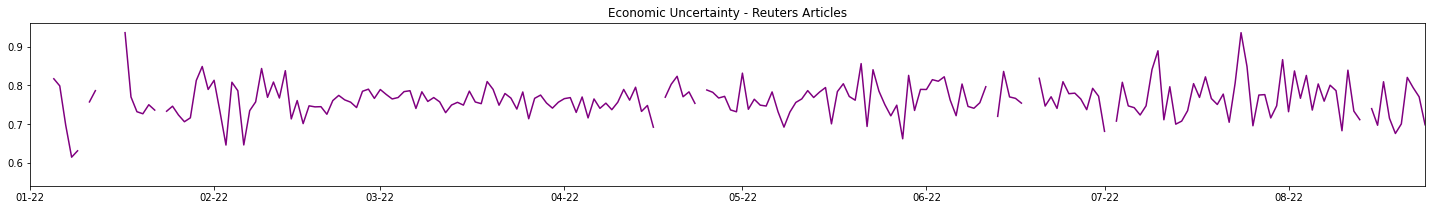

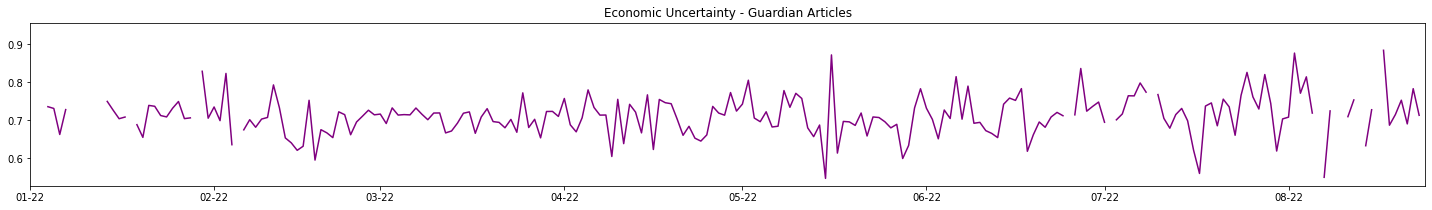

In [22]:
scatter_plot(reuters_unc_davg,"Economic Uncertainty - Reuters Articles","","")
scatter_plot(guardian_unc_davg,"Economic Uncertainty - Guardian Articles","","")